In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
from tqdm.auto import tqdm

# Set plotting style
from matplotlib import rcParams
# Type 2/TrueType fonts
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# Arial font
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"

# Paths and Configs
import yaml
with open('../configuration/config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
TEMPDIR = Path(config['TEMPDIR'])

In [2]:
#   DS-002A5: SEQ450-ND1-22-4-24_S1  # ND1-24-4-24 control Rep2
#   DS-002A6: SEQ450-ND2-22-4-24_S2  # ND2-22-4-24 Cph nanoDam Rep2
#   DS-002A7: SEQ450-ND1-24-4-24_S3  # ND1-24-4-24 control Rep1
#   DS-002A8: SEQ450-ND2-24-4-24_S4  # ND2-22-4-24 Cph nanoDam Rep1
samples = list(config['SAMPLES'].keys())

# MACS2

In [13]:
# Load peak data (BED6+3 format)
sample = samples[0]
sample = 'DS-002A8_vs_DS-002A7'
peaks = pd.read_csv(f"../results/tables/{sample}_annotated_peaks.csv", index_col=0, header=0)

In [14]:
peaks

,seqnames,start,end,width,strand,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS
1,chr2L,12470,12938,469,*,"Exon (FBtr0078170/FBgn0002121, exon 6 of 9)",1,7529,9484,1956,1,FBgn0031208,FBtr0475186,4941
2,chr2L,13342,14543,1202,*,"Exon (FBtr0078170/FBgn0002121, exon 4 of 9)",1,9839,18570,8732,2,FBgn0002121,FBtr0078170,4027
3,chr2L,15085,15655,571,*,Promoter (2-3kb),1,9839,18570,8732,2,FBgn0002121,FBtr0078170,2915
4,chr2L,18038,18544,507,*,Promoter (<=1kb),1,9839,18570,8732,2,FBgn0002121,FBtr0078170,26
5,chr2L,20843,21349,507,*,Promoter (<=1kb),1,9839,21376,11538,2,FBgn0002121,FBtr0078166,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21111,chrY,3208765,3208979,215,*,Promoter (2-3kb),7,3205803,3205967,165,1,FBgn0267893,FBtr0347442,2962
21112,chrY,3273921,3274197,277,*,Promoter (1-2kb),7,3272835,3273532,698,1,FBgn0267864,FBtr0347422,1086
21113,chrY,3279228,3279442,215,*,Distal Intergenic,7,3284939,3285868,930,1,FBgn0267490,FBtr0346739,-5497
21114,chrY,3437991,3438390,400,*,Distal Intergenic,7,3376224,3376984,761,1,FBgn0267427,FBtr0346755,61767


In [5]:
data = {}
for sample in samples:
    data[sample] = pd.read_csv(f"../results/tables/{sample}_annotated_peaks.csv", index_col=0, header=0)

# GATC binning

In [11]:
# Convert GATC to bedgraph fold change
for control, treated, replicate in zip((samples[0], samples[2]), (samples[1], samples[3]), ("Rep2", "Rep1")):
    df = pd.read_csv(TEMPDIR / f"damidseq_pipeline-1.5.3/{treated}.GATC.binned.csv", index_col=0, names=['idx', 'counts'])
    df_c = pd.read_csv(TEMPDIR / f"damidseq_pipeline-1.5.3/{control}.GATC.binned.csv", index_col=0, names=['idx', 'ctrl_counts'])

    tab = pd.concat([df, df_c], axis=1)
    tab['lfc'] = np.log2(tab['counts'] / tab['ctrl_counts'])
    tab['fc'] = tab['counts'] / tab['ctrl_counts']
    tab['chrom'] = tab.index.str.split(':').str[0]
    tab['start'] = tab.index.str.split(':').str[1].str.split('-').str[0].astype(int)
    tab['end'] = tab.index.str.split(':').str[1].str.split('-').str[1].astype(int)
    tab['name'] = tab.index

    # export as bedgraph
    stab = tab[~tab.fc.isna() & (tab.fc!=np.infty)].copy()
    stab[['chrom', 'start', 'end', 'fc']].to_csv(f"../results/tables/{replicate}.GATC.fc.bedgraph", sep='\t', header=False, index=False)

In [16]:
tab = pd.concat({sample: pd.read_csv(TEMPDIR / f"damidseq_pipeline-1.5.3/{sample}.GATC.binned.csv", index_col=0, names=['idx', f'counts_{sample}']) for sample in samples}, axis=1)
tab['chrom'] = tab.index.str.split(':').str[0]
tab['start'] = tab.index.str.split(':').str[1].str.split('-').str[0].astype(int)
tab['end'] = tab.index.str.split(':').str[1].str.split('-').str[1].astype(int)
tab.columns = tab.columns.droplevel(1)
tab.rename(columns={samples[0]: 'control_Rep2', samples[1]: 'treated_Rep2', samples[2]: 'control_Rep1', samples[3]: 'treated_Rep1'}, inplace=True)

"It is recommended to keep individual libraries with a Pearson correlation coefficient of ≥0.9 compared to libraries of the same type (i.e., among NanoDam-tagged protein samples or NanoDam-alone samples) and pairwise comparisons with a Pearson correlation coefficient of ≥0.8 among the other comparisons of the same type (e.g., NanoDam-tagged protein_vs_NanoDam-alone comparisons derived from the same experimental setup" - https://www.sciencedirect.com/science/article/pii/S2666166722006682?via%3Dihub#sec4:~:text=Code%20chunk%207

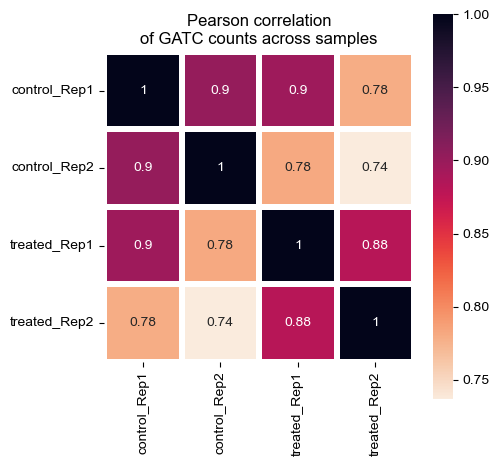

In [77]:
# calculate pearson correlation across samples
pw_corr = tab.iloc[:, :4].corr()
# sort alphabetically
pw_corr = pw_corr.sort_index(axis=0).sort_index(axis=1)
fig, ax = pl.subplots(figsize=(5, 5))
sns.heatmap(pw_corr, annot=True, cmap='rocket_r', ax=ax, linewidths=4)
ax.set_title("Pearson correlation\nof GATC counts across samples")
pl.yticks(rotation=0)
ax.set_aspect('equal')
fig.savefig(f"../results/figures/GATC_sample_corr.pdf", dpi=300, bbox_inches='tight')
pl.show()

# Visualize library complexity

In [6]:
# Read the preseq output file
dats = {}
for sample in samples:
    try:
        with open(f'../results/preseq/{sample}_complexity_estimate.txt', 'r') as f:
            lines = f.readlines()
    except FileNotFoundError:
        continue
    # Parse the data
    total_reads = []
    unique_reads = []
    for line in lines[1:]:  # Skip the header
        parts = line.strip().split('\t')
        total_reads.append(float(parts[0]))
        unique_reads.append(float(parts[1]))
    
    dats[sample] = pd.DataFrame({'total_reads': total_reads, 'unique_reads': unique_reads})
data = pd.concat(dats, axis=0).reset_index(level=0).rename(columns={'level_0': 'sample'})
data['sample_name'] = data['sample'].replace({samples[0]: 'control_Rep2', samples[1]: 'treated_Rep2', samples[2]: 'control_Rep1', samples[3]: 'treated_Rep1'})
data['replicate'] = data['sample'].replace({samples[0]: 'Rep2', samples[1]: 'Rep2', samples[2]: 'Rep1', samples[3]: 'Rep1'})
data['condition'] = data['sample'].replace({samples[0]: 'control', samples[1]: 'treated', samples[2]: 'control', samples[3]: 'treated'})

In [7]:
actual_values = pd.read_csv('../resources/fastqc_sequence_counts_plot.tsv', index_col=0, sep='\t')
actual_values['Total Reads'] = actual_values.sum(axis=1)
actual_values.replace({samples[0]: 'control_Rep2', samples[1]: 'treated_Rep2', samples[2]: 'control_Rep1', samples[3]: 'treated_Rep1'}, inplace=True)
actual_values['sample_name'] = actual_values.index
actual_values['replicate'] = actual_values.sample_name.replace({samples[0]: 'Rep2', samples[1]: 'Rep2', samples[2]: 'Rep1', samples[3]: 'Rep1'})
actual_values['condition'] = actual_values.sample_name.replace({samples[0]: 'control', samples[1]: 'treated', samples[2]: 'control', samples[3]: 'treated'})

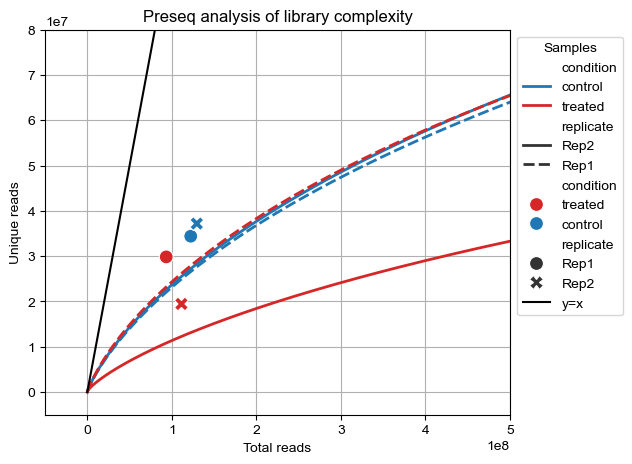

In [19]:
fig, ax = pl.subplots(figsize=(6, 5))
sns.lineplot(data=data, x='total_reads', y='unique_reads', 
             style='replicate', hue='condition',
             ax=ax, linewidth=2, palette={'control': 'tab:blue', 'treated': 'tab:red'}
             )

sns.scatterplot(data=actual_values, x='Total Reads', y='Unique Reads', ax=ax, 
                hue='condition', style='replicate', palette={'control': 'tab:blue', 'treated': 'tab:red'},
                s=100, legend=True, zorder=10)

# add diagonal line
x = np.linspace(1, 1e10, 1000)
ax.plot(x, x, 'k', label='y=x')
ax.set_ylim(-0.5*1e7, 0.8*1e8)
ax.set_xlim(-0.5*1e8, 0.5*1e9)

ax.grid(True)
ax.set_xlabel('Total reads')
ax.set_ylabel('Unique reads')
ax.set_title('Preseq analysis of library complexity')
pl.legend(title='Samples')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))



pl.savefig(f"../results/figures/preseq_complexity.pdf", dpi=300, bbox_inches='tight')
pl.show()

# Visualize DiffBind

In [16]:
genes_to_annotate = """sff
kuk
E2f1
CycE
nerfin-1
Sirup
peb
pros
Cph
HmgZ""".split('\n')

In [3]:
genes = pd.read_csv('../resources/genes/genes.csv', index_col=2)
genes.head()

,flybase_id,gene_name,chromosome,start_position,end_position,annotation
gene_symbol,,,,,,
CG9650,FBgn0029939,Cph,X,7137723,7241932,gene of interest
pros,FBgn0004595,pros,3R,11328480,11407627,gene of interest
HmgZ,FBgn0010228,HmgZ,2R,21697488,21707861,positive hit
corn,FBgn0259173,corn,3L,7142991,7157073,positive hit
fz2,FBgn0016797,fz2,3L,19140975,19235373,negative hit


In [4]:
# Convert Flybase IDs to gene names
# read gtf file; https://ftp.flybase.net/releases/current/dmel_r6.58/gtf/
gtf = pd.read_csv(TEMPDIR / 'genome/dmel-all-r6.58.gtf', sep='\t', comment='#',
                  names=['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'],
                  header=None)
gtf['gene_id'] = gtf['attribute'].str.extract(r'gene_id "(FBgn[0-9]+)"')
gtf['gene_symbol'] = gtf['attribute'].str.extract(r'gene_symbol "(.+?)"')
gtf.dropna(subset=['gene_id'], inplace=True)
gtf.drop_duplicates(subset=['gene_id'], inplace=True)
gtf.set_index('gene_id', inplace=True)
gtf['gene_id'] = gtf.index

anno_df = pd.read_csv('../results/diffbind/peak_anno.csv', index_col=0)  # annotated with CHIPseeker

anno_df_named = pd.merge(anno_df, gtf[['gene_symbol']], left_on='geneId', right_index=True, how='left')
anno_df_named['significance_score'] = -np.log10(anno_df_named['FDR'])
anno_df_named['group'] = ['up' if x > 0 and y < 0.05 else 'down' if x<0 and y<0.05 else 'n.s.' for x, y in zip(anno_df_named['Fold'], anno_df_named['FDR'])]
anno_df_named.to_csv('../results/tables/peak_anno_named.csv')

In [4]:
anno_df_named = pd.read_csv('../results/tables/peak_anno_named.csv', index_col=0)

In [5]:
anno_df_named.head()

,seqnames,start,end,width,strand,width.1,strand.1,Conc,Conc_Cph_NanoDam,Conc_control,...,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,gene_symbol,significance_score,group
1,chr3R,21662657,21663056,400,*,401,*,10.192821,6.397865,11.139892,...,21661186,21662972,1787,2,FBgn0038893,FBtr0084116,0,NaN,45.203512,down
2,chr2L,47259,47658,400,*,401,*,10.292127,11.187563,7.453856,...,54817,55767,951,1,FBgn0267987,FBtr0347585,-7159,lncRNA:CR46254,30.331965,up
3,chrX,3789785,3790184,400,*,401,*,10.054325,10.900032,7.752839,...,3789969,3792477,2509,1,FBgn0029676,FBtr0070598,0,HIP-R,21.540939,up
4,chr3L,16806423,16806822,400,*,401,*,10.738060,11.564912,8.593663,...,16787573,16807731,20159,2,FBgn0036663,FBtr0075344,909,CG9674,20.805974,up
5,chr3R,23723375,23723774,400,*,401,*,11.622494,12.493677,9.073190,...,23723331,23731499,8169,1,FBgn0039109,FBtr0084449,44,CG10365,20.795967,up


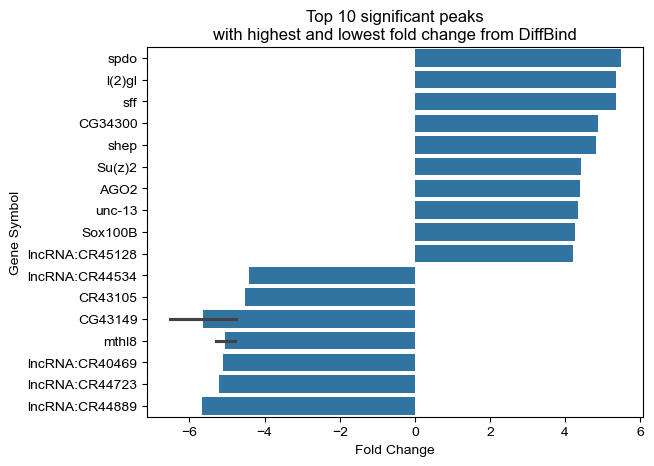

In [6]:
# plot top 10 significant peaks (5 highest fold and 5 lowest fold)
sig_df = anno_df_named[anno_df_named['FDR'] < 0.001].sort_values('Fold', ascending=False)
top_hits = sig_df.head(10)
top_hits = pd.concat([top_hits, sig_df.tail(10)])
sns.barplot(data=top_hits, x='Fold', y='gene_symbol', dodge=False)
pl.title('Top 10 significant peaks\nwith highest and lowest fold change from DiffBind')
pl.ylabel('Gene Symbol')
pl.xlabel('Fold Change')
pl.show()

In [41]:
!pip install adjustText

    torch (>=1.9.*)
           ~~~~~~^


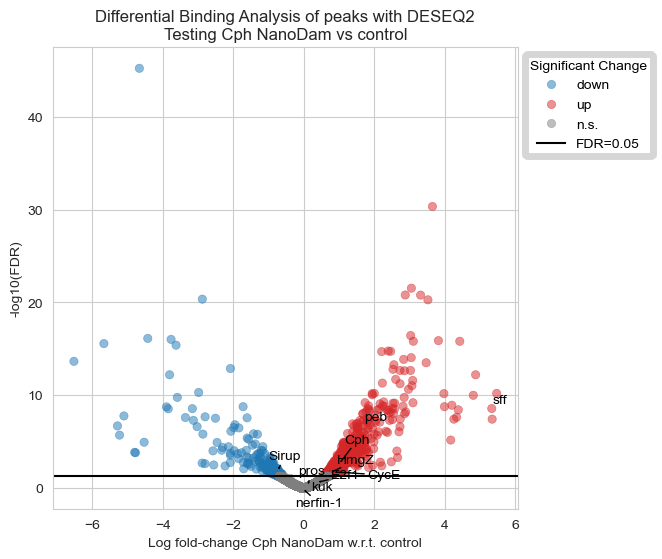

In [49]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(6,6))
# background scatter
x = anno_df_named.Fold
y = anno_df_named.significance_score

sns.scatterplot(x=x, y=y, hue=anno_df_named.group, ax=ax, alpha=0.5, 
                palette={'up': 'tab:red', 'down': 'tab:blue', 'n.s.': 'tab:gray'},
                edgecolor=None
                )

# # Annotate with text the top hits
texts = []
for gene in genes_to_annotate:
    row = anno_df_named[anno_df_named.gene_symbol == gene].iloc[0]
    # ax.text(row.Fold, row.significance_score, row.gene_symbol, fontsize=8)
    x = row.Fold
    y = row.significance_score
    texts.append(ax.text(x, y, row.gene_symbol))
from adjustText import adjust_text
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=1))


pl.axhline(-np.log10(0.05), label='FDR=0.05', c='k')
pl.legend(title='Significant Change')
pl.title('Differential Binding Analysis of peaks with DESEQ2\nTesting Cph NanoDam vs control')
pl.xlabel('Log fold-change Cph NanoDam w.r.t. control')
pl.ylabel('-log10(FDR)')
pl.savefig('../results/diffbind/diffbind_vulcanoplot.pdf', bbox_inches='tight')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

pl.show()

## Correlate diffbind with gene expression

In [4]:
# Correlate with gene expression data
gex_Cph_inhibition = pd.read_excel('../resources/edgeR_diff_expr_CphRNAi_Progenitor[3]_summary.xlsx', index_col=0, skiprows=1)
gex_Cph_overexpression = pd.read_excel('../resources/edgeR_diff_expr_CphUp_Progenitor[4]_summary.xlsx', index_col=0, skiprows=1)

In [5]:
anno_df_named = pd.read_csv('../results/tables/peak_anno_named.csv', index_col=0)
cross_data = pd.merge(anno_df_named, gex_Cph_inhibition, left_on='gene_symbol', right_index=True, how='inner')

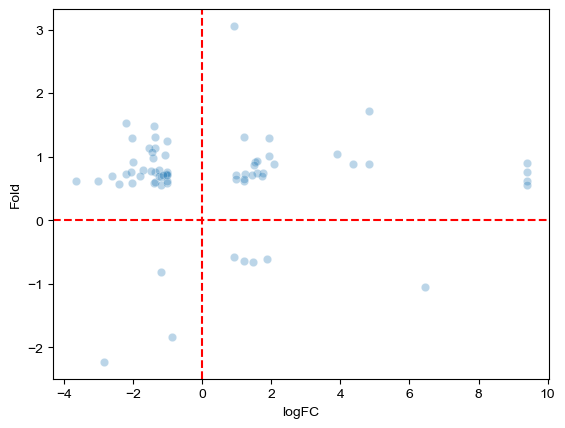

In [6]:
data = cross_data[(cross_data.FDR < 0.1) & (cross_data.p_adj < 0.1)]
sns.scatterplot(data=data, x='logFC', y='Fold', alpha=0.3)
pl.axhline(0, color='red', linestyle='--')
pl.axvline(0, color='red', linestyle='--')

In [7]:
# this is peak level, but should probably aggregate to gene level
# divide genes in whether they have a peak that is sig up or down or none at all
anno_df_named['signed_score'] = np.sign(anno_df_named['Fold']) * np.log10(anno_df_named['FDR']) * -1
maxs = anno_df_named.groupby('gene_symbol').agg({'signed_score': 'max'})
mins = anno_df_named.groupby('gene_symbol').agg({'signed_score': 'min'})

In [8]:
# for each gene the score of best peak and classification whether it was uniquely up, down, none or ambiguous
threshold = -np.log10(0.001)
ups = maxs[maxs.signed_score > threshold]
downs = mins[mins.signed_score < -threshold]
ambiguous_or_none = maxs[(maxs.signed_score > -threshold) & (mins.signed_score < threshold)]
# remove ambiguous from all others
ups = ups[~ups.index.isin(ambiguous_or_none.index)]
downs = downs[~downs.index.isin(ambiguous_or_none.index)]
gene_peak_summary = pd.concat({'up': ups, 'down': downs, 'ambiguous_or_none': ambiguous_or_none}, axis=0).reset_index(level=0).rename(columns={'level_0': 'direction'})

<Axes: xlabel='direction', ylabel='signed_score'>

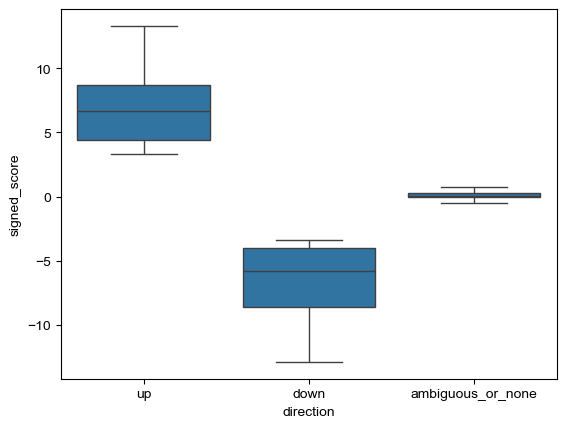

In [9]:
sns.boxplot(data=gene_peak_summary, x='direction', y='signed_score', showfliers=False)

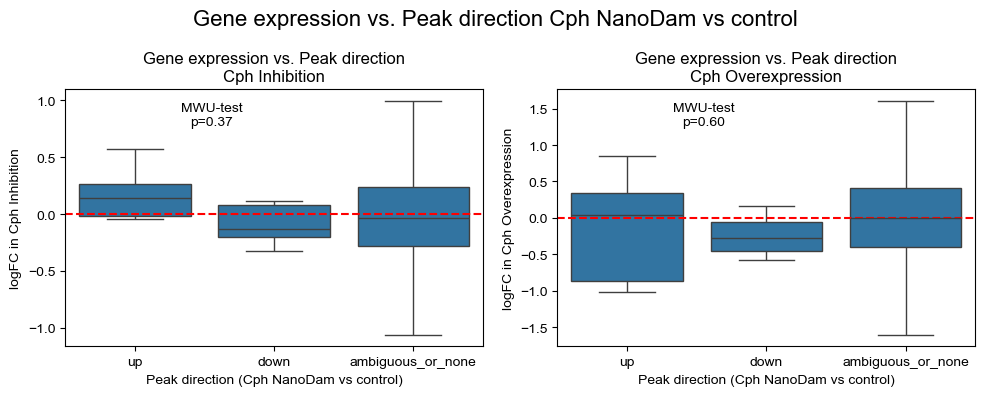

In [10]:
fig, axs = pl.subplots(1, 2, figsize=(10, 4))
for ax, dat, title in zip(axs, (gex_Cph_inhibition, gex_Cph_overexpression), ('Cph Inhibition', 'Cph Overexpression')):
    dat = pd.merge(gene_peak_summary, dat, left_on='gene_symbol', right_index=True, how='inner')
    sns.boxplot(data=dat, x='direction', y='logFC', showfliers=False, ax=ax)
    ax.set_ylabel(f'logFC in {title}')
    ax.set_xlabel('Peak direction (Cph NanoDam vs control)')
    ax.axhline(0, color='red', linestyle='--')
    ax.set_title(f'Gene expression vs. Peak direction\n{title}')
    
    from scipy.stats import mannwhitneyu
    up = dat[dat.direction == 'up']
    down = dat[dat.direction == 'down']
    u, p = mannwhitneyu(up.logFC, down.logFC)
    ax.text(0.35, 0.9, f'MWU-test\np={p:.2f}', transform=ax.transAxes, ha='center', va='center')
pl.suptitle('Gene expression vs. Peak direction Cph NanoDam vs control', fontsize=16)
pl.tight_layout()
pl.show()

## Gene-wise summaries

In [12]:
# Take peaks in promoter region, select significant ones and rank by fold change
sdf = anno_df_named[anno_df_named.annotation.str.contains('Promoter') | anno_df_named.annotation.str.contains('Exon')].copy()
sdf = sdf[sdf.FDR < 0.05]
gene_sdf = sdf.groupby('gene_symbol').sum().sort_values('Fold', ascending=False)
gene_sdf['rank'] = np.arange(1, len(gene_sdf)+1)

In [13]:
print(len(anno_df_named.gene_symbol.unique()))
gene_sdf.loc[['Cph']]

11540


,start,end,width,width.1,Conc,Conc_Cph_NanoDam,Conc_control,Fold,p.value,FDR,geneChr,geneStart,geneEnd,geneLength,geneStrand,distanceToTSS,significance_score,signed_score,rank
gene_symbol,,,,,,,,,,,,,,,,,,,
Cph,14431242,14432040,800,802,24.655264,25.842098,22.577727,2.136643,0.000154,0.00828,12,14422484,14483470,60988,2,8758,4.802255,4.802255,61


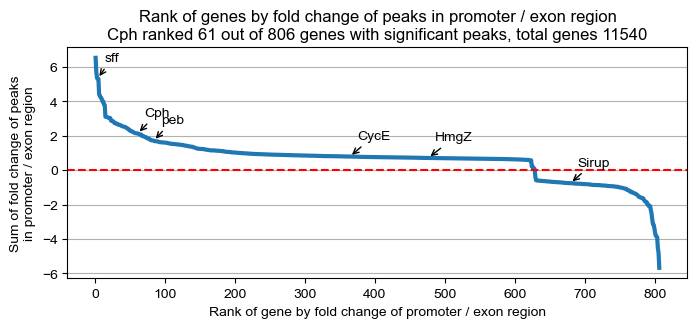

In [18]:
fig, ax = pl.subplots(figsize=(8, 3))
ax = sns.lineplot(data=gene_sdf, x='rank', y='Fold', linewidth=3)
for gene in genes_to_annotate:
    if gene not in gene_sdf.index:
        continue
    x = gene_sdf.loc[gene, 'rank']
    y = gene_sdf.loc[gene, 'Fold']
    ax.annotate(gene, xy=(x, y), 
                xytext=(x+10, y+1), 
                arrowprops=dict(arrowstyle='->'))
ax.set_xlabel('Rank of gene by fold change of promoter / exon region')
ax.set_ylabel('Sum of fold change of peaks\nin promoter / exon region')
ax.set_title(f'Rank of genes by fold change of peaks in promoter / exon region\nCph ranked {gene_sdf.loc["Cph", "rank"]} out of {len(gene_sdf)} genes with significant peaks, total genes {len(anno_df_named.gene_symbol.unique())}')
ax.axhline(0, color='red', linestyle='--')
ax.grid(True, axis='y')
pl.savefig('../results/figures/promoter_exon_peaks_ranked_lineplot.pdf', bbox_inches='tight')
pl.show()

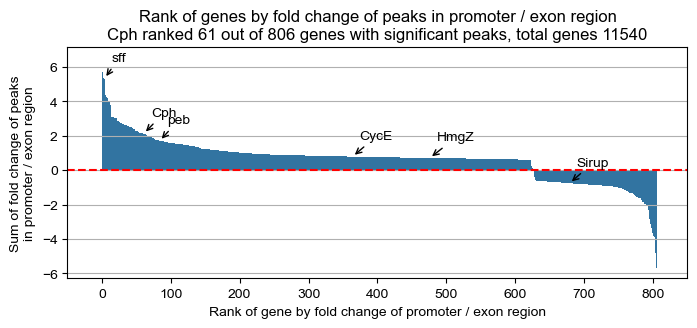

In [19]:
fig, ax = pl.subplots(figsize=(8, 3))
ax = sns.barplot(data=gene_sdf, x='rank', y='Fold', width=1)
for gene in genes_to_annotate:
    if gene not in gene_sdf.index:
        continue
    x = gene_sdf.loc[gene, 'rank']
    y = gene_sdf.loc[gene, 'Fold']
    ax.annotate(gene, xy=(x, y), 
                xytext=(x+10, y+1), 
                arrowprops=dict(arrowstyle='->'))
ax.set_xticks(np.arange(0, 9, 1)*100)
ax.set_xticklabels(np.arange(0, 9, 1)*100)
ax.set_xlim(-50, 850)
ax.set_xlabel('Rank of gene by fold change of promoter / exon region')
ax.set_ylabel('Sum of fold change of peaks\nin promoter / exon region')
ax.set_title(f'Rank of genes by fold change of peaks in promoter / exon region\nCph ranked {gene_sdf.loc["Cph", "rank"]} out of {len(gene_sdf)} genes with significant peaks, total genes {len(anno_df_named.gene_symbol.unique())}')
ax.axhline(0, color='red', linestyle='--')
ax.grid(True, axis='y')
pl.savefig('../results/figures/promoter_exon_peaks_ranked_barplot.pdf', bbox_inches='tight')
pl.show()

In [148]:
gene_sdf.to_csv('../results/tables/diffbind_gene_peak_summary_ranked_exon_promoter.csv')

## Finding negative controls

In [97]:
anno_df_named[anno_df_named.gene_symbol == 'Cph']

,seqnames,start,end,width,strand,width.1,strand.1,Conc,Conc_Cph_NanoDam,Conc_control,...,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,gene_symbol,significance_score
422,chrX,7198613,7199012,400,*,401,*,12.133988,12.672674,11.264527,...,6,7196029,7241932,45904,1,FBgn0029939,FBtr0309030,2584,Cph,2.527488
508,chrX,7232629,7233028,400,*,401,*,12.521276,13.169423,11.313199,...,6,7226455,7241538,15084,1,FBgn0029939,FBtr0474235,6174,Cph,2.274767
1575,chrX,7222482,7222881,400,*,401,*,11.410163,11.803817,10.867038,...,6,7226455,7241538,15084,1,FBgn0029939,FBtr0474234,-3574,Cph,1.095472
2234,chrX,7226619,7227018,400,*,401,*,11.648188,11.936436,11.287593,...,6,7226455,7241538,15084,1,FBgn0029939,FBtr0474235,164,Cph,0.833194
4921,chrX,7192328,7192727,400,*,401,*,10.999750,11.274000,10.660833,...,6,7196029,7241932,45904,1,FBgn0029939,FBtr0309030,-3302,Cph,0.410733
5759,chrX,7217039,7217438,400,*,401,*,8.553668,8.823489,8.221499,...,6,7226455,7241538,15084,1,FBgn0029939,FBtr0474234,-9017,Cph,0.345557
8620,chrX,7205638,7206037,400,*,401,*,10.096237,10.264659,9.905522,...,6,7196029,7241932,45904,1,FBgn0029939,FBtr0309030,9609,Cph,0.210981
12056,chrX,7188537,7188936,400,*,401,*,8.453608,8.122111,8.722986,...,6,7196029,7241932,45904,1,FBgn0029939,FBtr0309030,-7093,Cph,0.132018
14391,chrX,7137677,7138076,400,*,401,*,9.417978,9.535890,9.289565,...,6,7137723,7241538,103816,1,FBgn0029939,FBtr0339815,0,Cph,0.094304
14939,chrX,7220458,7220857,400,*,401,*,10.620602,10.442093,10.779435,...,6,7226455,7241538,15084,1,FBgn0029939,FBtr0474234,-5598,Cph,0.086211


In [128]:
length_genes = anno_df_named[(anno_df_named.geneLength < 60000) & (anno_df_named.geneLength > 35000)].gene_symbol.unique()

In [133]:
# negative control genes with similar length as Cph
df = anno_df_named[anno_df_named.gene_symbol.isin(length_genes)].copy()
df.groupby('gene_symbol').max().sort_values('FDR', ascending=False).head(10).iloc[:, 4:]

,strand,width.1,strand.1,Conc,Conc_Cph_NanoDam,Conc_control,Fold,p.value,FDR,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,significance_score
gene_symbol,,,,,,,,,,,,,,,,,,,
Pde11,*,401,*,14.235534,14.570099,13.799187,0.569170,0.998554,0.999471,Promoter (<=1kb),1,18532728,18572286,40262,2,FBgn0085370,FBtr0343830,14747,1.102133
rdx,*,401,*,13.060208,13.219544,12.881064,0.814451,0.998387,0.999434,Promoter (<=1kb),4,13967955,14025962,58008,2,FBgn0264493,FBtr0301634,19705,2.404874
hwt,*,401,*,11.667510,11.667976,11.667044,0.087237,0.997780,0.999274,Promoter (<=1kb),6,12516634,12568452,51819,2,FBgn0264542,FBtr0333155,15709,0.104764
CG30015,*,401,*,13.034533,13.457438,12.433703,0.584273,0.997353,0.999198,Promoter (<=1kb),2,10839102,10874771,35670,2,FBgn0050015,FBtr0331939,1921,1.079953
sima,*,401,*,14.119263,14.333658,13.867353,0.407040,0.994991,0.998676,Promoter (<=1kb),4,30099520,30121798,63488,1,FBgn0266411,FBtr0344376,12044,0.680280
ko,*,401,*,12.678655,12.704389,12.652453,1.001393,0.991796,0.997587,Promoter (<=1kb),3,21075581,21131159,55579,2,FBgn0020294,FBtr0333449,3980,2.934668
Muc14A,*,401,*,8.855739,8.858966,8.852504,0.001604,0.988256,0.996612,Promoter (2-3kb),6,16009114,16061722,52609,1,FBgn0052580,FBtr0074205,2872,0.001474
SK,*,401,*,9.953328,9.950498,9.956151,0.013220,0.988483,0.996612,Promoter (2-3kb),6,5358272,5401123,56883,1,FBgn0029761,FBtr0301954,-2039,0.009634
hiw,*,401,*,10.523192,10.521239,10.525142,0.249050,0.987868,0.996556,Promoter (<=1kb),6,15010137,15063429,53293,2,FBgn0030600,FBtr0346087,6753,0.369814


In [136]:
# negative control genes with similar length as Cph
df = anno_df_named[anno_df_named.gene_symbol.isin(length_genes)].copy()
df.Fold = np.abs(df.Fold)
df.groupby('gene_symbol').max().sort_values('Conc_Cph_NanoDam', ascending=True).head(10).iloc[:, 4:]

,strand,width.1,strand.1,Conc,Conc_Cph_NanoDam,Conc_control,Fold,p.value,FDR,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,significance_score
gene_symbol,,,,,,,,,,,,,,,,,,,
CG30116,*,401,*,7.835329,7.592805,8.042889,0.101615,0.576203,0.869527,"Intron (FBtr0086719/FBgn0028496, intron 2 of 18)",2,18456602,18498026,41425,2,FBgn0028496,FBtr0086719,10777,0.106766
CG43366,*,401,*,8.009973,7.706158,8.260804,0.094670,0.430816,0.794088,Promoter (1-2kb),2,5893895,5931363,37469,1,FBgn0263109,FBtr0307307,-1269,0.100131
Dop2R,*,401,*,8.085213,7.835997,8.297654,0.064343,0.569668,0.866210,Distal Intergenic,6,20004680,20062706,58027,2,FBgn0053517,FBtr0343171,-9109,0.062377
CG43373,*,401,*,8.616576,8.031246,9.031798,0.304057,0.061063,0.354809,"Exon (FBtr0307367/FBgn0263131, exon 4 of 31)",3,16491838,16543370,51533,2,FBgn0263131,FBtr0307367,13615,0.450005
dpr10,*,401,*,8.636870,8.093810,9.030491,0.508427,0.010312,0.128848,"Exon (FBtr0076307/FBgn0000451, exon 7 of 8)",3,10147454,10186108,38655,2,FBgn0052057,FBtr0331552,-4767,0.889924
Tmtc2,*,401,*,9.320894,8.142767,10.014526,0.751601,0.240993,0.652584,Promoter (2-3kb),1,922793,958098,35306,1,FBgn0028481,FBtr0305064,17570,1.320890
Ance-3,*,401,*,8.247948,8.144509,8.344464,0.057434,0.591193,0.875194,Promoter (<=1kb),1,13914725,13956188,41464,1,FBgn0032536,FBtr0343641,628,0.057896
lncRNA:CR31386,*,401,*,8.574743,8.154406,8.899842,0.166856,0.213728,0.622945,"Intron (FBtr0308921/FBgn0051386, intron 3 of 4)",4,11269415,11305608,36194,2,FBgn0051386,FBtr0308921,20087,0.205550
CG32432,*,401,*,8.462549,8.281980,8.623011,0.071035,0.553437,0.857004,"Intron (FBtr0078268/FBgn0052432, intron 2 of 19)",3,20844332,20885188,40857,2,FBgn0052432,FBtr0078268,6161,0.067017


In [139]:
df = anno_df_named[anno_df_named.gene_symbol.isin(length_genes)].copy()
df.groupby('gene_symbol').size().sort_values(ascending=True).head(10)

gene_symbol
mew          1
CG32547      1
side-VIII    1
tnc          1
eIF4EHP      1
dpr10        1
CG4168       1
Dop2R        1
axo          1
CG43366      1
dtype: int64

In [142]:
anno_df_named[anno_df_named.gene_symbol == 'CG32547']

,seqnames,start,end,width,strand,width.1,strand.1,Conc,Conc_Cph_NanoDam,Conc_control,...,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,gene_symbol,significance_score
802,chrX,18478894,18479293,400,*,401,*,8.904113,9.338926,8.278768,...,6,18443027,18479487,36461,2,FBgn0052547,FBtr0332378,194,CG32547,1.732616


## Compare with Brain data

In [153]:
brain_df = pd.read_csv('../resources/Nick_brain_NanoDam_TaDa/NanoDam_targets_all.tsv', sep='\t', index_col=1)
gene_sdf = pd.read_csv('../results/tables/diffbind_gene_peak_summary_ranked_exon_promoter.csv', index_col=0)

In [154]:
brain_df

,rank,combined_binding_score,chr,start,end,transcript,FBid
gene,,,,,,,
CG9650,1,19.411863,X,7137723.0,7137724.0,FBtr0301240,FBgn0029939
Cyp12e1,2,18.102417,3R,10434789.0,10434790.0,FBtr0301283,FBgn0037817
rpr,3,11.846754,3L,18398434.0,18398435.0,FBtr0075120,FBgn0011706
CG15233,4,9.291242,2R,6600977.0,6600978.0,FBtr0305958,FBgn0033076
kn,5,8.612892,2R,14797026.0,14797027.0,FBtr0329882,FBgn0001319
...,...,...,...,...,...,...,...
CG15631,2211,0.025833,2L,4734457.0,4734458.0,FBtr0077419,FBgn0031626
Pngl,2212,0.022125,2R,6017739.0,6017740.0,FBtr0085972,FBgn0033050
regucalcin,2213,0.017625,X,12012377.0,12012378.0,FBtr0073575,FBgn0030362


In [155]:
gene_sdf

,start,end,width,width.1,Conc,Conc_Cph_NanoDam,Conc_control,Fold,p.value,FDR,geneChr,geneStart,geneEnd,geneLength,geneStrand,distanceToTSS,significance_score,rank
gene_symbol,,,,,,,,,,,,,,,,,,
CG9098,24049631,24051227,1600,1604,37.968510,40.533723,32.897346,6.536615,1.074113e-04,5.580904e-03,4,24029597,24048247,18654,8,-2182,23.249891,1
Sox21b,42386621,42387818,1200,1203,26.330926,28.424763,21.945550,5.687270,2.316230e-05,1.655143e-03,9,42337215,42393918,56706,6,6499,20.093894,2
l(2)gl,20775,21174,400,401,7.194432,8.174349,2.017704,5.350608,1.269094e-10,3.606263e-08,1,9839,21376,11538,2,202,7.442943,3
sff,15928825,15929224,400,401,7.201948,8.179632,2.176256,5.339911,6.141578e-12,2.590034e-09,3,15900156,15924861,24706,2,-3964,8.586694,4
Plp,60310786,60312382,1600,1604,40.741237,43.077670,36.632431,5.314813,2.734263e-05,2.143771e-03,12,60264964,60313920,48960,8,2316,20.412381,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CR32010,25846,26245,400,401,8.426409,5.194752,9.347498,-3.844142,6.854657e-12,2.755251e-09,5,13153,25054,11902,2,-792,8.559839,802
Nf-YB,19737208,19737607,400,401,7.851177,4.555145,8.775801,-3.894626,3.966044e-12,1.729263e-09,1,19736044,19737088,1045,1,1164,8.762139,803
CR43105,15375441,15375840,400,401,6.704924,2.208141,7.672614,-4.529317,6.886633e-08,1.093572e-05,2,15374846,15375702,857,2,0,4.961153,804


In [160]:
merged_df = pd.merge(gene_sdf, brain_df, left_index=True, right_index=True, how='inner', suffixes=('_diffbind', '_brain'))

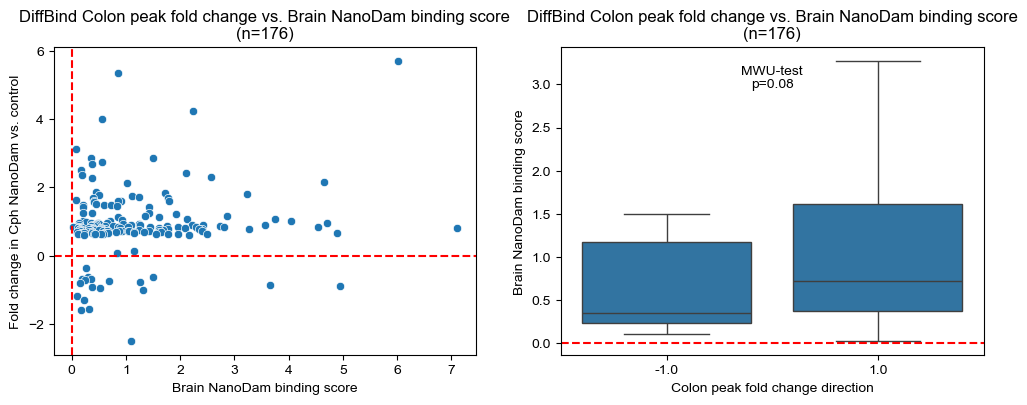

In [177]:
fig, axs = pl.subplots(1, 2, figsize=(12, 4))
ax = axs[0]
sns.scatterplot(data=merged_df, x='combined_binding_score', y='Fold',ax=ax)
ax.axhline(0, color='red', linestyle='--')
ax.axvline(0, color='red', linestyle='--')
ax.set_title(f'DiffBind Colon peak fold change vs. Brain NanoDam binding score\n(n={len(merged_df)})')
ax.set_xlabel('Brain NanoDam binding score')
ax.set_ylabel('Fold change in Cph NanoDam vs. control')

ax = axs[1]
merged_df['Fold_sign'] = np.sign(merged_df['Fold'])
sns.boxplot(data=merged_df, x='Fold_sign', y='combined_binding_score', showfliers=False,ax=ax)
ax.axhline(0, color='red', linestyle='--')
ax.set_title(f'DiffBind Colon peak fold change vs. Brain NanoDam binding score\n(n={len(merged_df)})')
ax.set_xlabel('Colon peak fold change direction')
ax.set_ylabel('Brain NanoDam binding score')

from scipy.stats import mannwhitneyu
up = merged_df[merged_df.Fold_sign == 1]
down = merged_df[merged_df.Fold_sign == -1]
u, p = mannwhitneyu(up.combined_binding_score, down.combined_binding_score)
ax.text(0.5, 0.9, f'MWU-test\np={p:.02f}', transform=ax.transAxes, ha='center', va='center')

pl.show()